In [1]:
import numpy as np
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
from utils import * # tic toc imshow
%load_ext line_profiler

import higra as hg
hg.set_trace(False)
hg.logger_register_print_callback()

Image size: (481, 321)


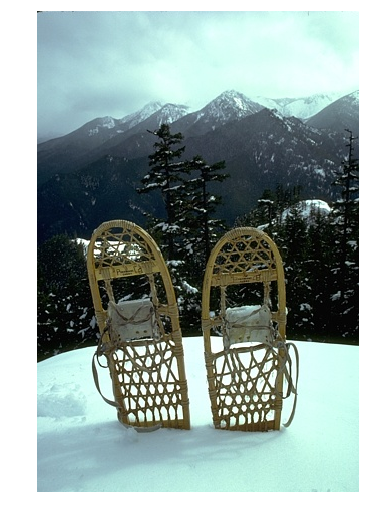

In [2]:
image = imageio.imread("data/2018.ppm")
# switch to float to avoir numerical issue with uint8
image = image.astype(np.float64)/255 
# discard the color channel
size = image.shape[:2]
print("Image size:", size)
imshow(image)

In [3]:
import scipy.io as sio
cob_results = sio.loadmat("data/2018_cob.mat")


In [4]:
for k in cob_results:
    print(k)

__header__
__version__
__globals__
E
O
im
times
ucm2
ucm_pre
ucms


# Oriented watershed test

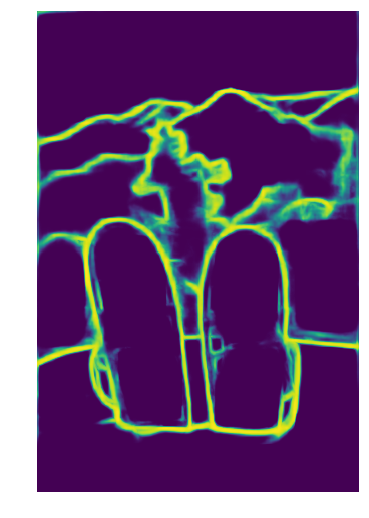

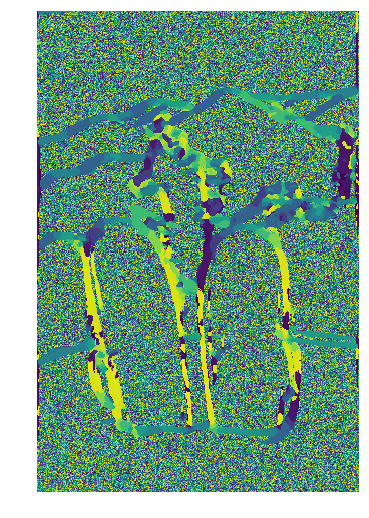

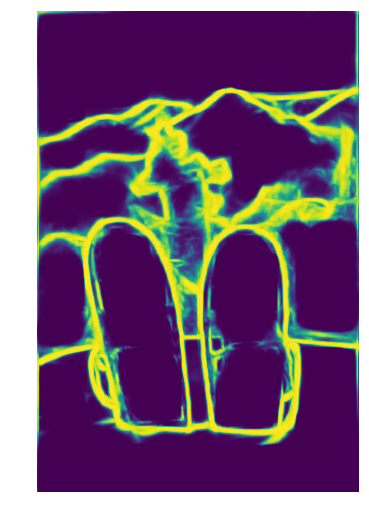

In [5]:
gradient = cob_results["E"][0][1]
gradient_orientation = cob_results["O"]["angle"][0][0]
gradient_confidence = cob_results["O"]["conf"][0][0]
gradient_confidence = np.max(gradient_confidence, axis=2)
gradient = gradient * gradient_confidence
imshow(gradient)
imshow(gradient_orientation)
imshow(gradient_confidence)


In [6]:
graph = hg.get_4_adjacency_graph(gradient.shape)
edge_weights = hg.weight_graph(gradient, hg.WeightFunction.mean, graph)
edge_orientations = hg.weight_graph(gradient_orientation, hg.WeightFunction.mean, graph)

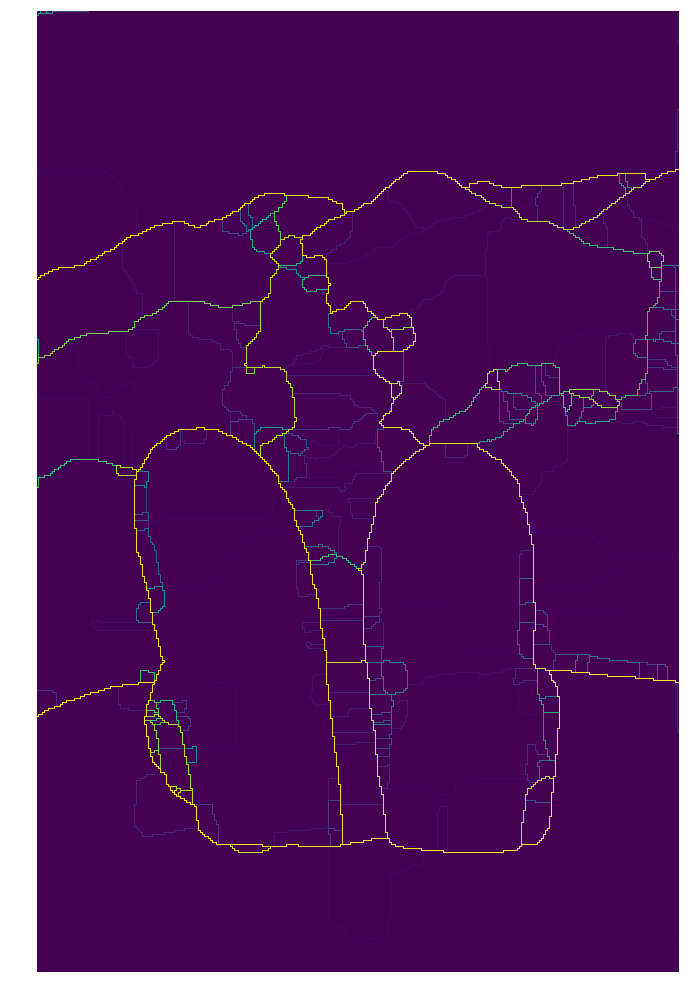

In [7]:
#%%timeit
tree, altitudes = hg.mean_pb_hierarchy(edge_weights)
sm_graph = hg.saliency(altitudes)
sm_viz = hg.graph_4_adjacency_2_khalimsky(sm_graph)
sm_viz = 1./(1+np.exp(-4*(sm_viz-0.8)))
imshow(sm_viz)

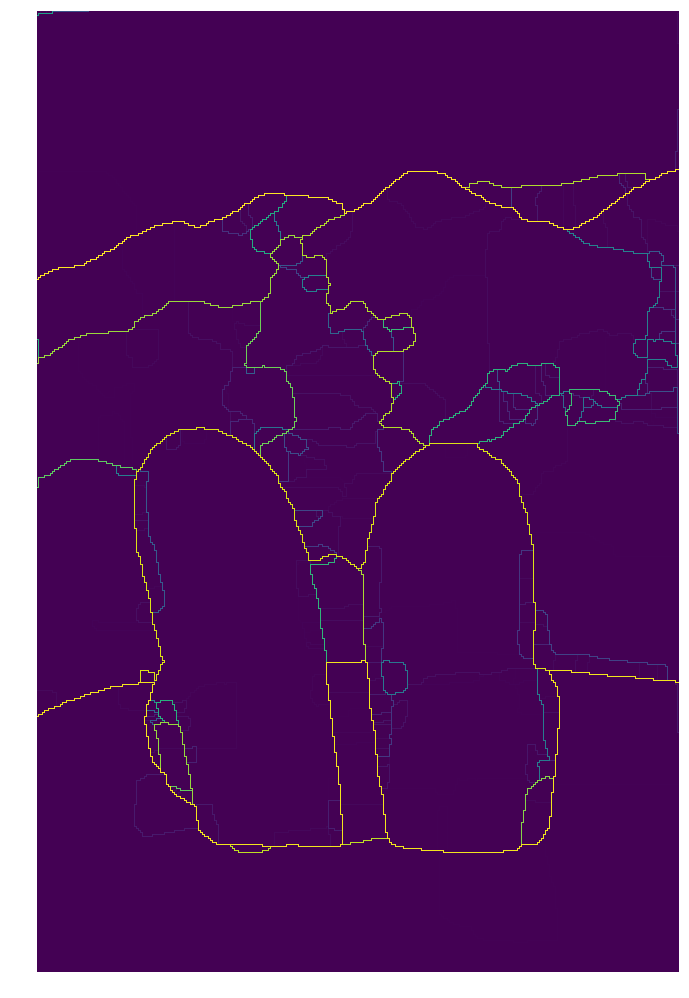

In [29]:
#%%timeit
tree, altitudes = hg.mean_pb_hierarchy(edge_weights, edge_orientations=edge_orientations)
sm_graph = hg.saliency(altitudes)
sm_viz = hg.graph_4_adjacency_2_khalimsky(sm_graph)
sm_viz = 1./(1+np.exp(-4*(sm_viz-0.8)))
imshow(sm_viz)

(2, 1)


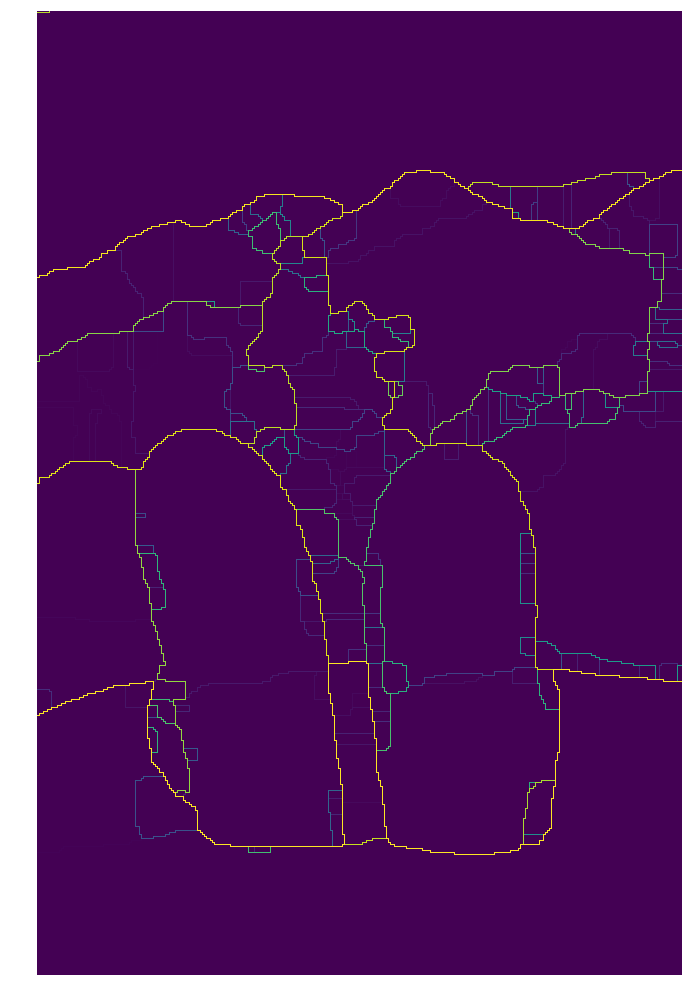

In [9]:
cob_ucm = cob_results["ucm_pre"]
print(cob_ucm.shape)

imshow(cob_ucm[1][0])

# Hierarchy combination test

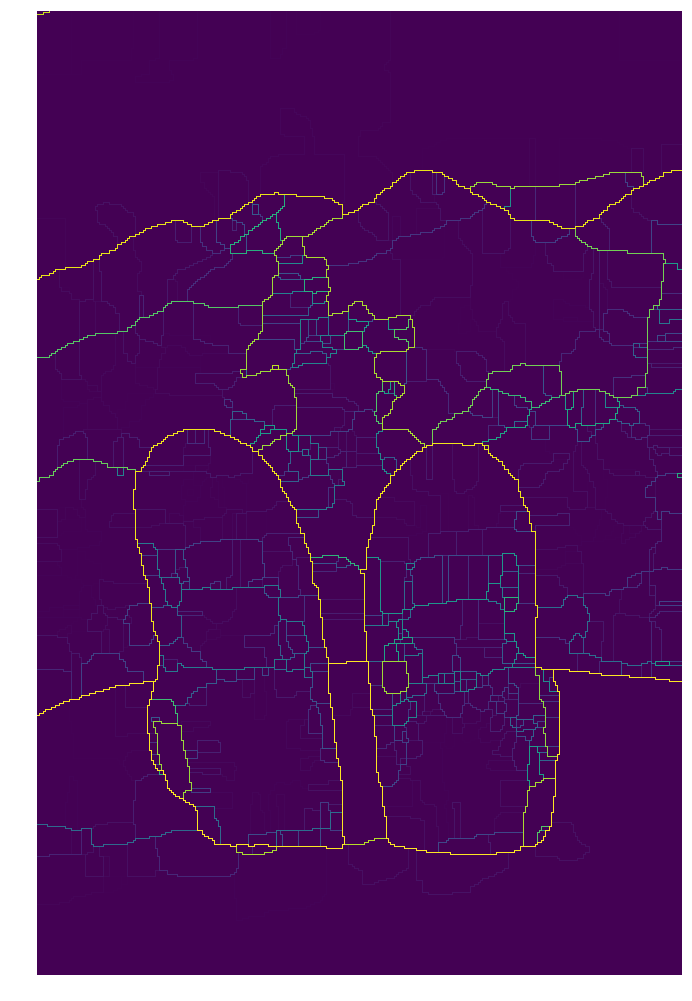

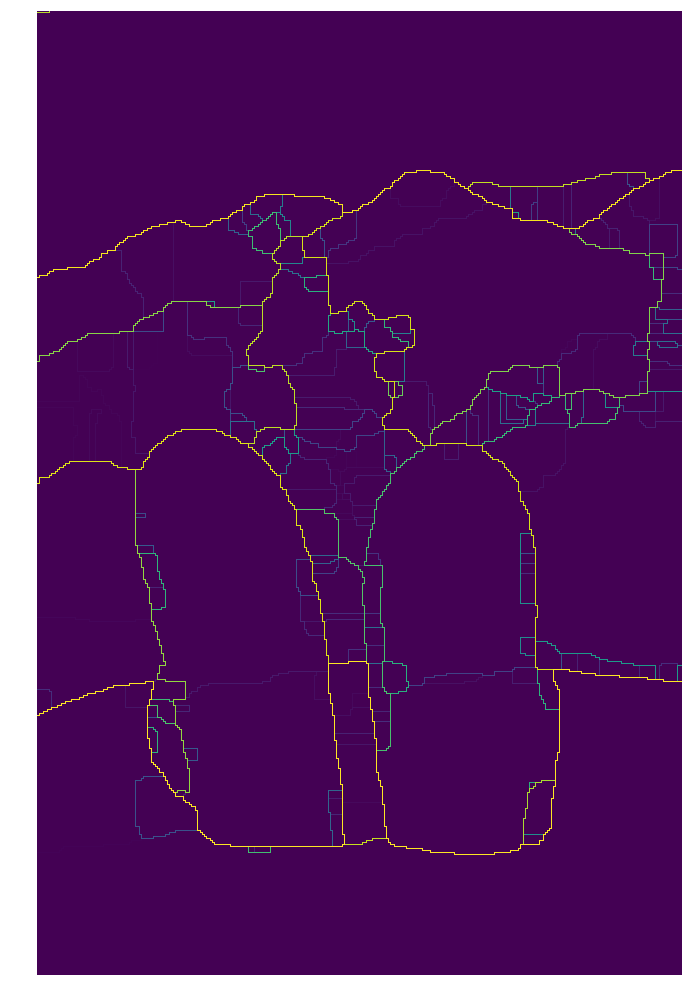

In [10]:
ucm_coarse = cob_ucm[1][0]
ucm_fine = cob_ucm[0][0]
imshow(ucm_fine)
imshow(ucm_coarse)

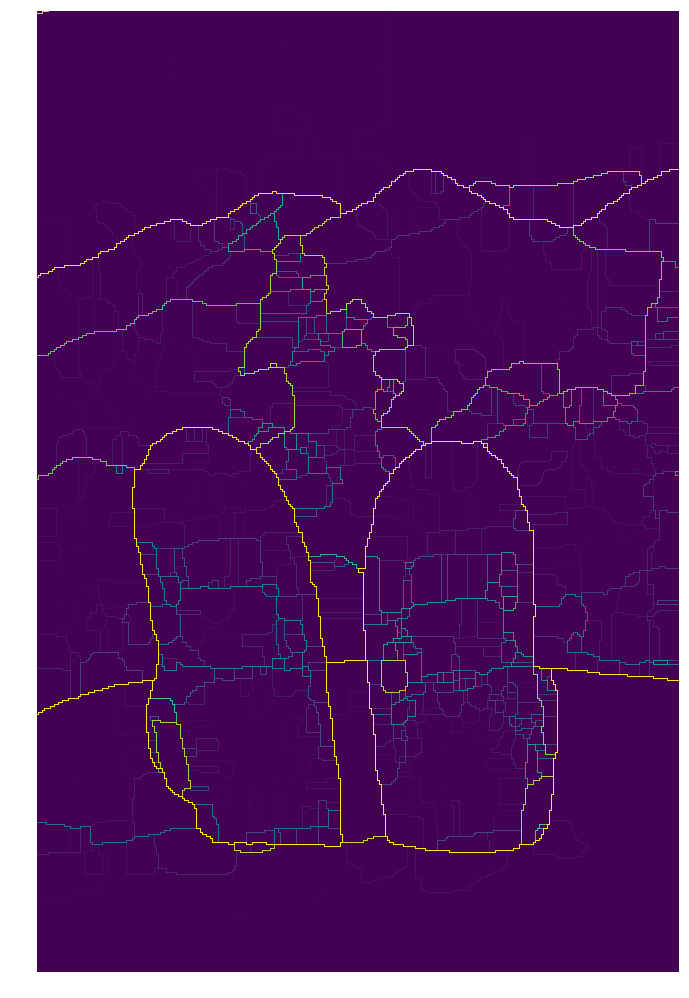

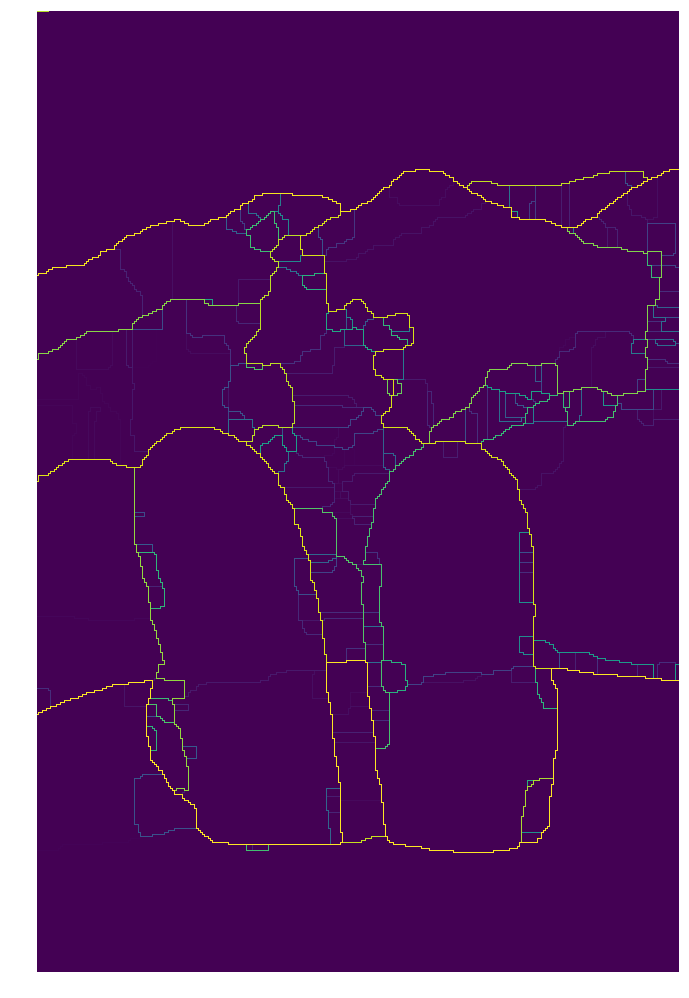

In [11]:
graph, sm_coarse = hg.khalimsky_2_graph_4_adjacency(ucm_coarse, extra_border=True)
graph, sm_fine = hg.khalimsky_2_graph_4_adjacency(ucm_fine, extra_border=True)
s = hg.get_attribute(sm_fine,"shape")

imshow(hg.graph_4_adjacency_2_khalimsky(sm_fine))
imshow(hg.graph_4_adjacency_2_khalimsky(sm_coarse))

In [12]:
superpixels_fine = hg.graph_cut_2_labelisation(sm_fine)
superpixels_coarse = hg.graph_cut_2_labelisation(sm_coarse)


In [13]:
rag_fine = hg.make_region_adjacency_graph_from_labelisation(superpixels_fine)
superpixels_fine = hg.get_attribute(rag_fine, "vertex_map")
rag_coarse = hg.make_region_adjacency_graph_from_labelisation(superpixels_coarse)
superpixels_coarse = hg.get_attribute(rag_coarse, "vertex_map")

In [14]:
fine_to_coarse_map = hg.project_fine_to_coarse_labelisation(superpixels_fine, superpixels_coarse)
#num_coarse_regions = np.amax(superpixels_coarse) + 1
#random_colors_coarse = np.random.randint(0, 256, (num_coarse_regions,3))
#random_colors_superpixels_coarse = random_colors_coarse[superpixels_coarse, :]

#imshow(random_colors_superpixels_coarse.reshape((*size,3)))
#imshow(random_colors_coarse[fine_to_coarse_map[superpixels_fine], :].reshape((*size,3)))

In [15]:
sm_rag_fine = hg.rag_accumulate_on_edges(rag_fine, hg.Accumulators.max, sm_fine)

      

In [16]:


sm_rag_coarse = hg.rag_accumulate_on_edges(rag_coarse, hg.Accumulators.max, sm_coarse)
tree_coarse, altitudes_coarse = hg.bpt_canonical(sm_rag_coarse)
LCAfast = hg.LCAFast(tree_coarse)
sm_rag_coarse = np.zeros_like(sm_rag_fine)

for e in rag_fine.edges():
    lca = LCAfast.lca(fine_to_coarse_map[e[0]], fine_to_coarse_map[e[1]])
    sm_rag_coarse[e[2]] = altitudes_coarse[lca]
   
    


In [17]:
def show_rag_sm(sm, rag):
    sm_g = hg.rag_back_project_edge_weights(sm, rag)
    k = hg.graph_4_adjacency_2_khalimsky(sm_g)
    imshow(k)
    

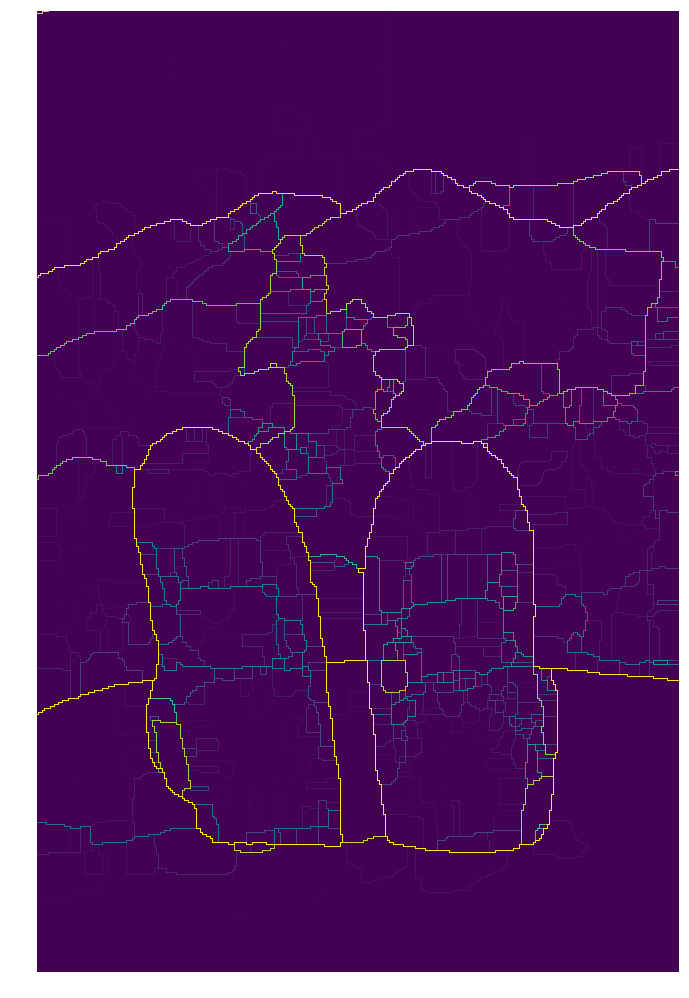

In [18]:
show_rag_sm(sm_rag_fine, rag_fine)

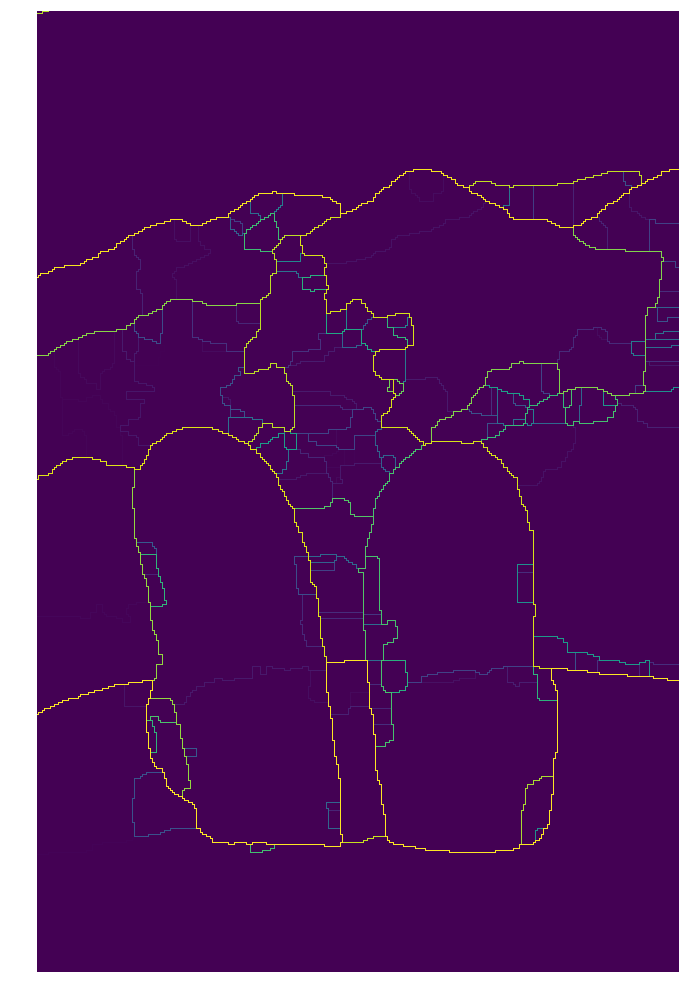

In [19]:
show_rag_sm(sm_rag_coarse, rag_fine)

In [22]:
hg.CptSaliencyMap.link(sm_coarse, graph)

In [23]:
superpixels_fine = hg.graph_cut_2_labelisation(sm_fine)
ucm_coarse_aligned = hg.align_hierarchies(superpixels_fine, sm_coarse)

In [24]:
print(ucm_coarse_aligned.shape)

(308000,)


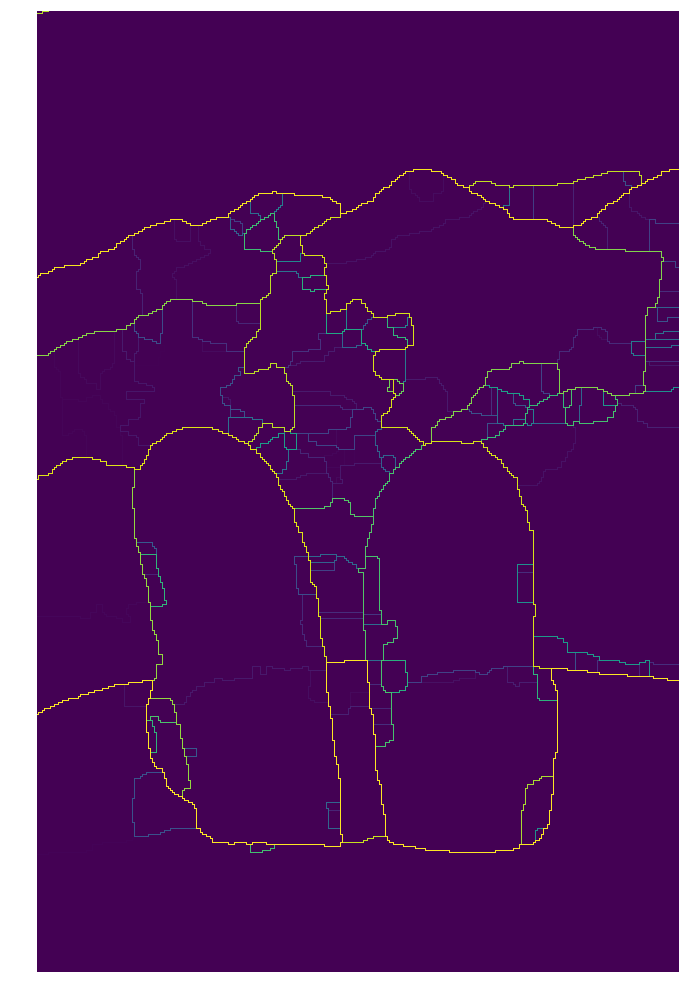

In [26]:

imshow(hg.graph_4_adjacency_2_khalimsky(ucm_coarse_aligned))

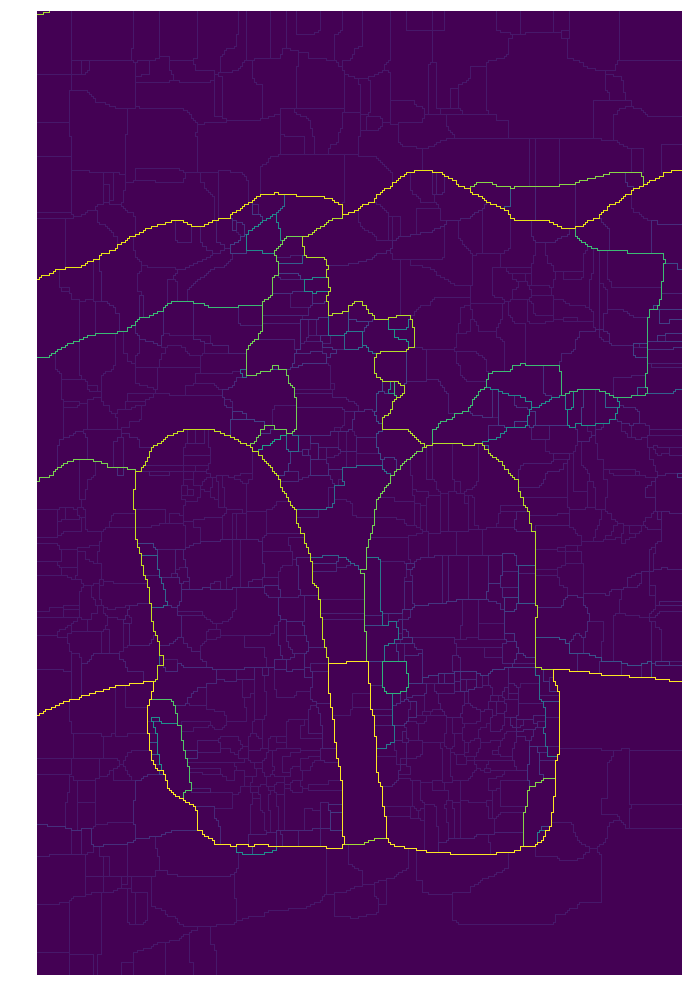

In [28]:
imshow(cob_results["ucm2"])